In [1]:
from feature_engine.datetime import DatetimeFeatures

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
import warnings
from sklearn.exceptions import ConvergenceWarning
import re

In [3]:
df = pd.read_csv("ad_10000records.csv")

In [4]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


In [5]:
print("Number of Null of features of Dataset is:")
print(df.isna().sum().sort_values())

Number of Null of features of Dataset is:
Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Gender                      0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64


In [6]:
print("Columns of features of Dataset is:")
print(df.columns)

Columns of features of Dataset is:
Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Gender', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')


In [7]:
df.columns = df.columns.str.replace(" ", "_")
print(df.columns)

Index(['Daily_Time_Spent_on_Site', 'Age', 'Area_Income',
       'Daily_Internet_Usage', 'Ad_Topic_Line', 'City', 'Gender', 'Country',
       'Timestamp', 'Clicked_on_Ad'],
      dtype='object')


In [8]:
print("Info of features of Dataset is:")
print(df.info())

Info of features of Dataset is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily_Time_Spent_on_Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area_Income               10000 non-null  float64
 3   Daily_Internet_Usage      10000 non-null  float64
 4   Ad_Topic_Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked_on_Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB
None


In [9]:
print("Shape of Dataset is:")
print(df.shape)

Shape of Dataset is:
(10000, 10)


In [10]:
print(f"Duplicates in Dataset is:{df.duplicated().sum()},({100*df.duplicated().sum()/len(df)})%")

Duplicates in Dataset is:215,(2.15)%


In [11]:
print("Cardinality of categorical features in datasets is:")
print(df.select_dtypes(include="object").nunique())

Cardinality of categorical features in datasets is:
Ad_Topic_Line    559
City             521
Gender             2
Country          207
Timestamp        567
dtype: int64


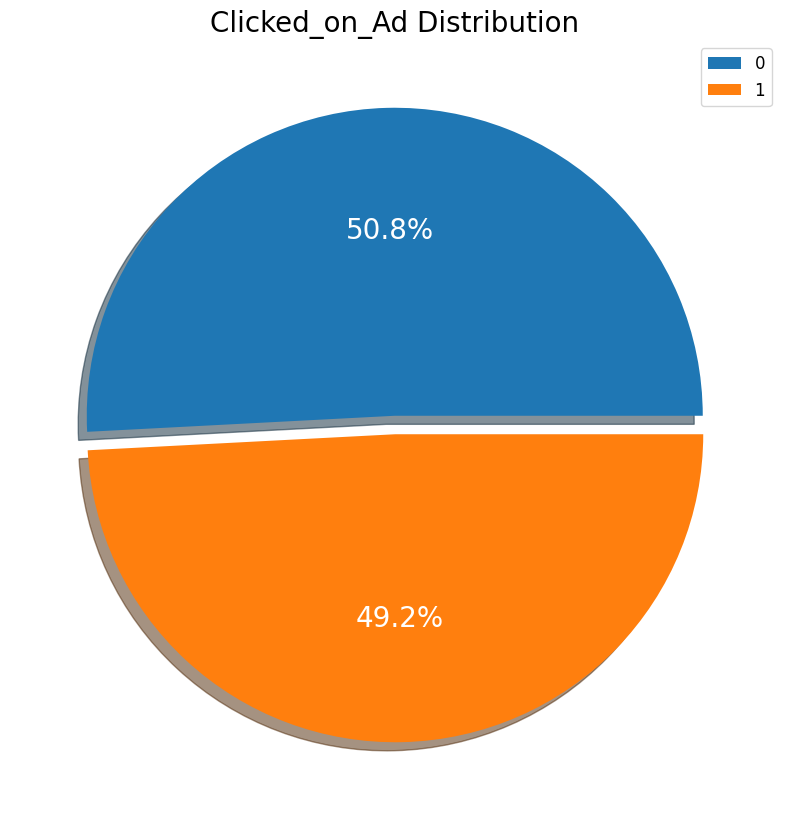

In [12]:
plt.subplots(figsize=(25, 10))
plt.pie(df.Clicked_on_Ad.value_counts(), shadow=True, explode=[.03,.03], autopct='%1.1f%%', textprops={'fontsize': 20, 'color': 'white'})
plt.title('Clicked_on_Ad Distribution', size=20)
plt.legend(['0', '1'], loc='best', fontsize=12)
plt.show()

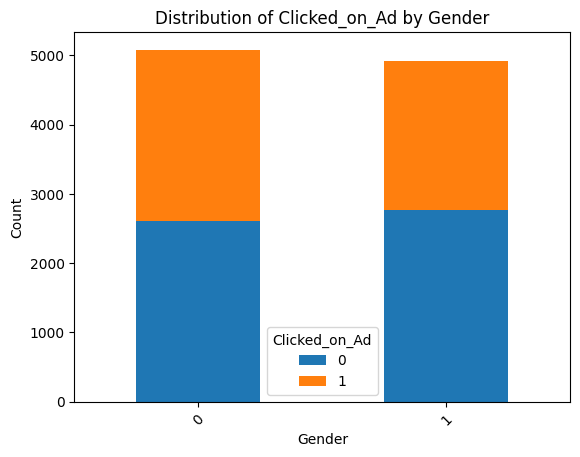

,count,sum,mean
,Clicked_on_Ad,Clicked_on_Ad,Clicked_on_Ad
Gender,,,
Female,5376,2767,0.514695
Male,4624,2150,0.464965


In [13]:
ct = pd.crosstab(df['Clicked_on_Ad'], df['Gender'])

ct.plot(kind='bar', stacked=True)
plt.title('Distribution of Clicked_on_Ad by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Clicked_on_Ad', labels=['0', '1'])
plt.show()

df.pivot_table(index="Gender", values="Clicked_on_Ad", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

In [14]:
df.pivot_table(index="Country", values="Clicked_on_Ad", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

,count,sum,mean
,Clicked_on_Ad,Clicked_on_Ad,Clicked_on_Ad
Country,,,
Afghanistan,38,30,0.789474
Albania,96,65,0.677083
Algeria,174,42,0.241379
American Samoa,91,16,0.175824
Andorra,13,2,0.153846
Angola,40,0,0.000000
Anguilla,11,5,0.454545
Antigua and Barbuda,10,10,1.000000


In [15]:
def bin_data(df, column_name, bin_size, num_bins, new_column_name):
    for i in range(int(num_bins)):
        lower_bound = bin_size * i
        upper_bound = bin_size * (i + 1)
        df.loc[(df[column_name] >= lower_bound) & (df[column_name] < upper_bound), new_column_name] = i

In [16]:
def plot_heatmap_and_crosstab(data, index_col, columns_col, value_col):
    pivot_table = data.pivot_table(index=index_col, columns=columns_col, values=value_col, aggfunc='mean')

    plt.subplots(figsize=(10, 5))
    heatmap = sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
    heatmap.set_title(f'Clicked_on_Ad ratio by {index_col} and {columns_col}', weight='bold', size=15)
    heatmap.set_xlabel(columns_col, weight='bold', size=13)
    heatmap.set_ylabel(index_col, weight='bold', size=13)
    plt.show()

    crosstab = pd.crosstab([data[index_col], data[value_col]], data[columns_col], margins=True)
    display(crosstab.style.background_gradient())

In [17]:
def plot_bar(train_df, x, y):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x=x, y=y, data=train_df, hue=x, dodge=False)
    ax.set_title('Bar Plot of {} & {}'.format(y, x))
    plt.show()

def plot_box(train_df, x, y):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x=x, y=y, data=train_df, hue=x)
    ax.set_title('Box Plot of {} & {}'.format(y, x))
    plt.show()

def plot_violin(train_df, x, y):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.violinplot(x=x, y=y, data=train_df, hue=x)
    ax.set_title('Violin Plot of {} & {}'.format(y, x))
    plt.show()

def plot_distribution(train_df, x, y=None, hue=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    if hue:
        sns.histplot(data=train_df, x=x, hue=hue, kde=True, multiple='stack')
    else:
        sns.histplot(data=train_df, x=x, kde=True, color='blue')
    ax.set_title('Distribution Plot of {}'.format(x))
    plt.show()

In [18]:
tmp = df.copy()

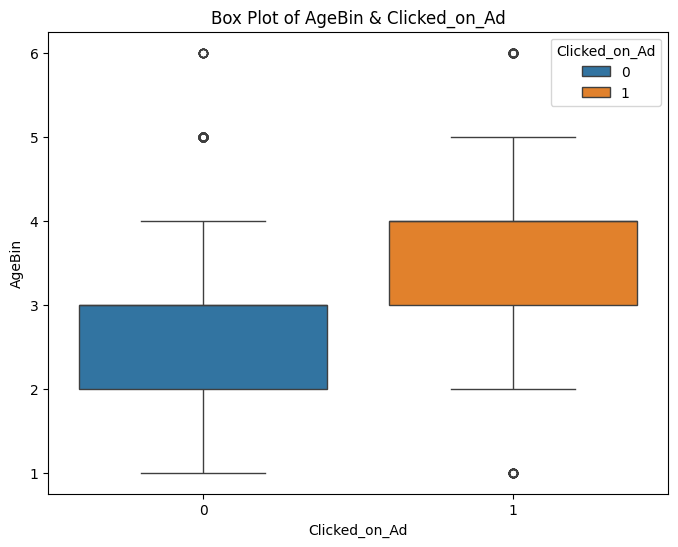

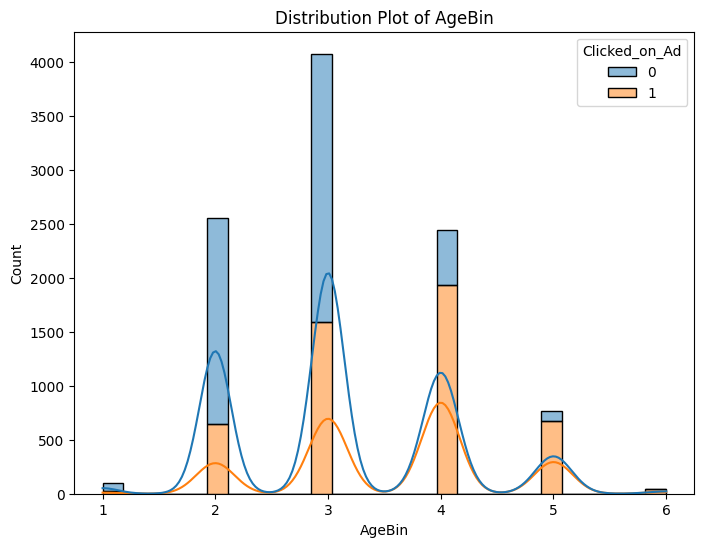

In [19]:
bin_data(tmp, 'Age', 10, 7, 'AgeBin')

plot_box(tmp, 'Clicked_on_Ad', 'AgeBin')
plot_distribution(tmp, 'AgeBin', hue='Clicked_on_Ad')

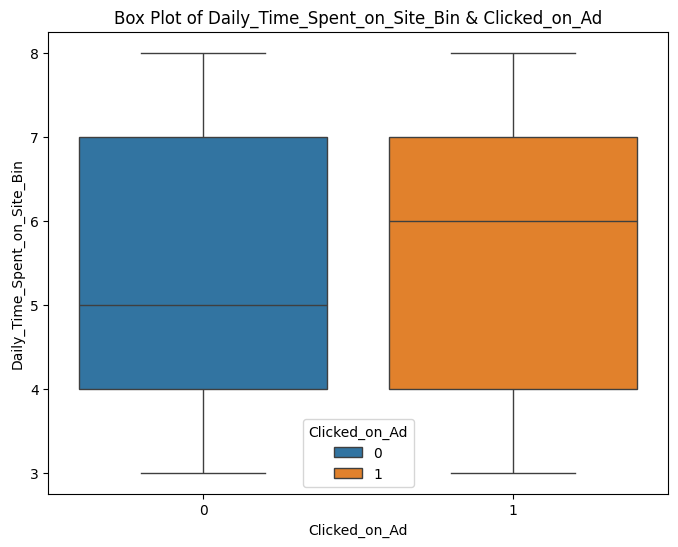

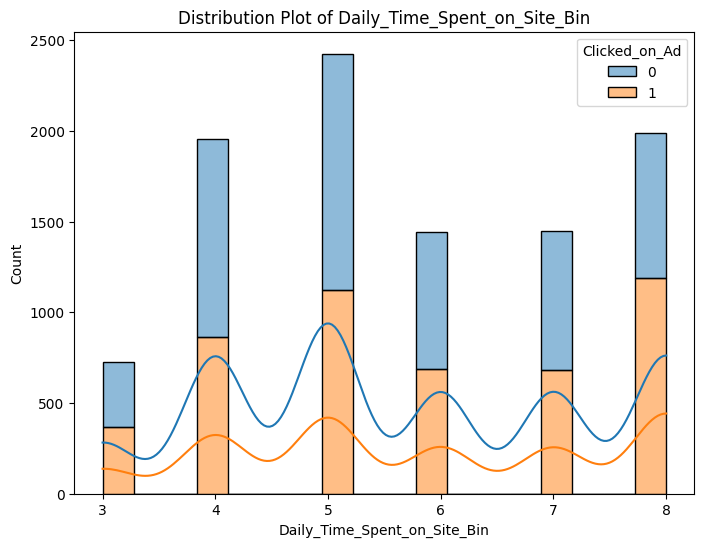

In [20]:
bin_data(tmp, 'Daily_Time_Spent_on_Site', 10, 9, 'Daily_Time_Spent_on_Site_Bin')

plot_box(tmp, 'Clicked_on_Ad', 'Daily_Time_Spent_on_Site_Bin')
plot_distribution(tmp, 'Daily_Time_Spent_on_Site_Bin', hue='Clicked_on_Ad')

In [21]:
X = df.drop(['Clicked_on_Ad'], axis=1)
y = df['Clicked_on_Ad']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
numerical_features = ['Daily_Time_Spent_on_Site', 
                      'Age', 
                      'Area_Income', 
                      'Daily_Internet_Usage']

categorical_features = ['City', 
                        'Gender', 
                        'Ad_Topic_Line', 
                        'Country']

In [24]:
for col in categorical_features:
    print(f"Value counts for {col}:")
    print(X_train[col].value_counts())
    print("\n")

Value counts for City:
City
Hubbardmouth         266
West Brandonton      220
Lisafort             208
Wintersfort          179
Reyesfurt            171
                    ... 
Cameronberg            1
Elizabethstad          1
Port Michealburgh      1
Davidview              1
Coffeytown             1
Name: count, Length: 506, dtype: int64


Value counts for Gender:
Gender
Female    4303
Male      3697
Name: count, dtype: int64


Value counts for Ad_Topic_Line:
Ad_Topic_Line
Cloned explicit middleware                 278
Streamlined homogeneous analyzer           167
Business-focused transitional solution     158
Sharable reciprocal project                150
Intuitive exuding service-desk             140
                                          ... 
Visionary multi-tasking alliance             1
Open-source stable paradigm                  1
Stand-alone national attitude                1
Exclusive multi-state Internet solution      1
Object-based modular functionalities         1
Nam

In [25]:
def labeling(train, test):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    for col in categorical_features:
        train_col_reshaped = train[col].values.reshape(-1, 1)
        test_col_reshaped = test[col].values.reshape(-1, 1)
        
        train[col] = oe.fit_transform(train_col_reshaped)
        
        test[col] = oe.transform(test_col_reshaped)
        

In [26]:
labeling(X_train, X_test)

In [27]:
X_train.head()

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Ad_Topic_Line,City,Gender,Country,Timestamp
9254,74.15,31.0,59677.64,207.17,419.0,259.0,1.0,15.0,2016-07-09 11:18:02
1561,72.80,29.0,73910.90,195.69,224.0,24.0,1.0,189.0,2016-01-05 16:26:44
1670,42.04,40.0,39723.97,165.27,97.0,315.0,0.0,27.0,2016-06-12 21:21:53
6087,66.18,49.0,45632.51,124.32,430.0,185.0,0.0,24.0,2016-03-11 00:05:48
6669,44.57,36.0,50628.31,168.92,112.0,52.0,1.0,167.0,2016-06-20 08:22:09


In [28]:
df_transformer = DatetimeFeatures(features_to_extract=['year', 'month', 'day_of_month', 'hour', 'minute', 'second'])

df_transformer.fit(X_train)

X_train = df_transformer.transform(X_train)
X_test = df_transformer.transform(X_test)

In [29]:
X_train.head()

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Ad_Topic_Line,City,Gender,Country,Timestamp_year,Timestamp_month,Timestamp_day_of_month,Timestamp_hour,Timestamp_minute,Timestamp_second
9254,74.15,31.0,59677.64,207.17,419.0,259.0,1.0,15.0,2016,7,9,11,18,2
1561,72.80,29.0,73910.90,195.69,224.0,24.0,1.0,189.0,2016,1,5,16,26,44
1670,42.04,40.0,39723.97,165.27,97.0,315.0,0.0,27.0,2016,6,12,21,21,53
6087,66.18,49.0,45632.51,124.32,430.0,185.0,0.0,24.0,2016,3,11,0,5,48
6669,44.57,36.0,50628.31,168.92,112.0,52.0,1.0,167.0,2016,6,20,8,22,9


In [30]:
X_train.head()

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Ad_Topic_Line,City,Gender,Country,Timestamp_year,Timestamp_month,Timestamp_day_of_month,Timestamp_hour,Timestamp_minute,Timestamp_second
9254,74.15,31.0,59677.64,207.17,419.0,259.0,1.0,15.0,2016,7,9,11,18,2
1561,72.80,29.0,73910.90,195.69,224.0,24.0,1.0,189.0,2016,1,5,16,26,44
1670,42.04,40.0,39723.97,165.27,97.0,315.0,0.0,27.0,2016,6,12,21,21,53
6087,66.18,49.0,45632.51,124.32,430.0,185.0,0.0,24.0,2016,3,11,0,5,48
6669,44.57,36.0,50628.31,168.92,112.0,52.0,1.0,167.0,2016,6,20,8,22,9


In [31]:
best_score = 0
best_model = None
for i in range (1 , 12):
    if i == 1:
        model = SVC(kernel="rbf")
    elif i == 2 :
        model = LogisticRegression()
    elif i == 3:
        model = LinearDiscriminantAnalysis()
    elif i == 4:
        model = QDA()
    elif i == 5:
        model = RandomForestClassifier()
    elif i == 6:
        model = DecisionTreeClassifier()
    elif i == 7:
        model = AdaBoostClassifier()
    elif i == 8:
        model = xgb.XGBClassifier()
    elif i == 9:
        model = KNeighborsClassifier()
    elif i == 10:
        model = LinearDiscriminantAnalysis()
    else:
        model = GaussianNB()



    scores = cross_val_score(model, X_train, y_train, cv=5 , scoring='f1')
    score = scores.mean()
    print( f"{i}   _   {model} :" )
    print(scores)
    
    if score > best_score :
        best_score = score
        best_model = model

1   _   SVC() :
[0.50505051 0.52332657 0.54350736 0.53989362 0.49662618]


c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

2   _   LogisticRegression() :
[0.66933868 0.72458172 0.61092824 0.68818593 0.69071476]
3   _   LinearDiscriminantAnalysis() :
[0.72775214 0.73276428 0.69893899 0.72348993 0.71371505]


c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


4   _   QuadraticDiscriminantAnalysis() :
[0.63303189 0.6475     0.61015175 0.52255892 0.69545709]
5   _   RandomForestClassifier() :
[0.84368869 0.83837733 0.83557262 0.83496412 0.84590587]
6   _   DecisionTreeClassifier() :
[0.75047862 0.75336323 0.77763659 0.77001271 0.76214511]


c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\navid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

7   _   AdaBoostClassifier() :
[0.7895082  0.77380952 0.75543837 0.77363515 0.76831683]
8   _   XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) :
[0.87169568 0.86337396 0.8560558  0.85768985 0.86551944]
9   _   KNeighborsClassifier() :
[0.73500967 0.74747475 0.7193426  0.74474857 0.7082802

In [32]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"f1 :{f1_score(y_test, y_pred, average='binary')}")
    print(f"precision : {precision_score(y_test, y_pred, average='binary')}")
    print(f"recall : {recall_score(y_test, y_pred, average='binary')}")
    print(f"accuracy : {accuracy_score(y_test, y_pred)}")
    global conf_matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    

In [33]:
evaluate_model(best_model, X_train, y_train, X_test, y_test)

f1 :0.8829098156452416
precision : 0.8677766895200784
recall : 0.8985801217038539
accuracy : 0.8825


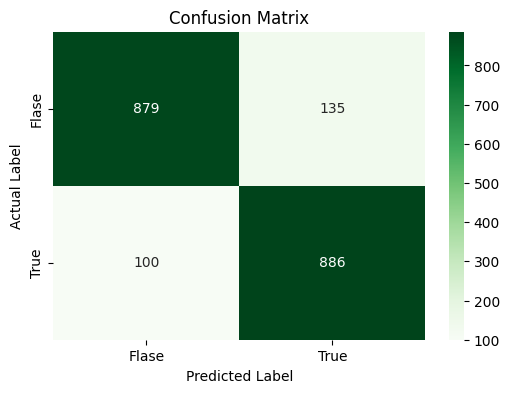

In [34]:
conf_matrix
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Flase', 'True'], yticklabels=['Flase', 'True'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Dataset Overview
The dataset, named ad_10000records.csv, contains information about advertisements, including whether they were clicked on (Clicked_on_Ad) and demographic details of the viewers such as gender (Gender), age, daily time spent on site, area income, city, country, ad topic line, and more. The dataset has been loaded into a Pandas DataFrame for manipulation and analysis.

### Initial Observations
- Null Values: The dataset contains no null values across its features.
- Column Names: Column names have been standardized by replacing spaces with underscores for consistency.
- Data Types: The dataset primarily consists of numerical and categorical data types.
- Duplicates: There are no duplicates in the dataset.
- Categorical Features Cardinality: The cardinality of categorical features varies, indicating different levels of granularity in these categories.
### Visualizations
- A pie chart showing the distribution of clicks on ads indicates a balanced class distribution between clicked and non-clicked ads.
- A bar chart stacked by gender shows the distribution of clicks on ads across genders.
- Pivot tables provide insights into the count, sum, and mean of clicks on ads grouped by gender and country.
# Feature Engineering
### Binning of Continuous Variables
Continuous variables like Age and Daily_Time_Spent_on_Site have been binned into discrete categories to facilitate further analysis and modeling.

### Visualization of Distributions
- Box plots and violin plots have been used to visualize the distribution of clicks on ads across different bins of age and daily time spent on site.
- Histograms show the distribution of binned age and daily time spent on site, colored by whether the ad was clicked on.
# Preprocessing
Categorical features have been encoded using ordinal encoding to convert them into a format suitable for machine learning models.

# Model Evaluation
Various machine learning models have been evaluated using cross-validation to determine their performance in predicting whether an ad will be clicked on based on viewer demographics and other factors.

### Models Evaluated
- Support Vector Classifier (SVC)
- Logistic Regression
- Linear Discriminant Analysis (LDA)
- Quadratic Discriminant Analysis (QDA)
- Random Forest Classifier
- Decision Tree Classifier
- AdaBoost Classifier
- eXtreme Gradient Boosting (XGBoost)
- k-Nearest Neighbors (KNN)
- Gaussian Naive Bayes
### Performance Metrics
Each model's performance has been assessed using F1-score, precision, recall, and accuracy metrics. The model achieving the highest F1-score has been selected as the best performing model.

### Confusion Matrix
A confusion matrix has been plotted to visually represent the performance of the best-performing model, providing insight into the model's ability to correctly classify ads as clicked or not clicked.